# **Training Code**

Train a multi-class classification model to identify storage I/O behaviors of a server workload as one of the following determined I/O patterns:

*   File Servers
*   OLTP
*   Streaming Reads
*   Streaming Writes
*   Web Servers
*   Workstations

## Mount Storage

Mount Google Drive to load model and dataset afterward.

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Must have:
- List of logman performance counters: `selected_counters.txt`
- Training Dataset: `training_dataset`

In [3]:
%cd /content/drive/MyDrive/HPE_APO/ML\ Model/Training
!ls

/content/drive/MyDrive/HPE_APO/ML Model/Training
selected_counters.txt  training_dataset  Training.ipynb


## Prepare

### Fix Random Seed

Fix random seed for reproducibility.

In [4]:
import numpy as np
import torch

def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(0)

### Declare Constants

In [5]:
N_SAMPLES = 61      # 5-min sampling duration & 5-sec sampling rate
N_COUNTERS = 103    # Performace counters
N_CLASSES = 6       # I/O patterns
IOPATTERN_TO_LABEL = {
    "File_Server": 0,
    "OLTP": 1,
    "Streaming_Reads": 2,
    "Streaming_Writes": 3,
    "Web_Server": 4,
    "Workstations": 5,
}

## Build Dataset



### Read Raw Data
1. Read `csv` files, which are the profiling results from `logman`.
    * One data instance contains 61 samples of 103 performance counters.
        * 5-min sampling duration & 5-sec sampling rate
2. Extract features, the performance counters we care about, within the effective duration (the effective duration in our experiment is the last 5 minutes of the profiling).


In [6]:
import numpy as np
import pandas as pd
import re

# Get extracted counters
def get_counter(counter_path):
    if not counter_path.exists:
        raise Exception("counter is not found")

    with counter_path.open("r") as f:
        lines = f.readlines()

    return [line.strip() for line in lines]

# Rename counters, e.g., process(fio) -> process(app)
def rename_counter(df):
    rename_list = {}
    for col_name in df.columns:
        new_col_name = re.sub("^Process\([\w#]+\)", "Process(app)", col_name)
        rename_list.update({col_name: new_col_name})

    return df.rename(columns=rename_list)

# Extract samples within the effective duration
def filter_rows(df):
    df = df[-1-N_SAMPLES:-1]
    return df

def check_format(instance, file):
    # Check null value
    if np.any(np.isnan(instance)):
        raise Exception("instance contains null data")

    # Check the shape of instance is (N_SAMPLES, N_COUNTERS)
    if instance.shape != (N_SAMPLES, N_COUNTERS):
        raise Exception("Shape of file {} is {}.".format(file, instance.shape))

def get_instances_and_labels(data_subdir, counters):
    if not data_subdir.exists:
        raise Exception("directory not found")

    instances, labels = [], []

    for file in data_subdir.iterdir():
        # Get instance
        df = pd.read_csv(file)
        df = rename_counter(df)
        df = df[counters]
        df = filter_rows(df)
        df = df.replace(regex="\s", value=0.0)
        instance = df.astype("float").to_numpy()
        check_format(instance, file)
        instances.append(instance)

        # Get label
        f_str = str(file.name)
        groups = re.match("^([File_Server|OLTP|Streaming_Reads|Streaming_Writes|Web_Server|Workstations]+)_", f_str)
        iopattern = groups.group(1)
        labels.append(IOPATTERN_TO_LABEL[iopattern])

    return instances, labels

def preprocess(data_dir, counter_path):
    instances, labels = [], []

    counters = get_counter(counter_path)

    data_subdirs = [file for file in data_dir.iterdir() if file.is_dir()]
    for data_subdir in data_subdirs:
        new_instances, new_labels = get_instances_and_labels(data_subdir, counters)
        instances.extend(new_instances)
        labels.extend(new_labels)

    # Convert array to numpy array
    data = {
        "instances": np.stack(instances, axis=0),
        "labels": np.stack(labels, axis=0),
    }

    return data

Save data in Python's data structure to avoid time-consuming I/Os from reading `csv` files.
* `cache`: directory for temporary data.

In [14]:
import os
from pathlib import Path
import pickle

data_dir = Path("training_dataset")
counter_path = Path("selected_counters.txt")
cache_dir = Path("cache")

# If preprocessed data exists in cache folder, load it directly.
IS_CACHED = True

# Create a cache directory
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)
    IS_CACHED = False

# Read data
data_cpath = cache_dir / "data.pickle"
IS_CACHED = IS_CACHED and os.path.exists(data_cpath)
if IS_CACHED:
    with data_cpath.open("rb") as f:
        data = pickle.load(f)
else:
    data = preprocess(data_dir, counter_path)
    with data_cpath.open("wb") as f:
        pickle.dump(data, f)

### Split Data

Split the labeled data into training set and validation set.
* Modify the variable `VAL_RATIO` to change the ratio of two sets.

In [15]:
from sklearn.model_selection import train_test_split

instances, labels = data["instances"], data["labels"]

VAL_RATIO = 0.1
x_train, x_val, y_train, y_val = train_test_split(instances, labels, test_size=VAL_RATIO, random_state=7)

print("Size of train set: {}".format(x_train.shape))
print("Size of validation set: {}".format(x_val.shape))

Size of train set: (4550, 61, 103)
Size of validation set: (506, 61, 103)


### Create Dataset

In [16]:
import torch
from torch.utils.data import Dataset

class HPEAPODataset(Dataset):
    def __init__(self, data, label=None):
        self.data = torch.from_numpy(data).float()
        if label is not None:
            label = label.astype(np.int)
            self.label = torch.LongTensor(label)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return self.data.shape[0]

train_set = HPEAPODataset(x_train, y_train)
val_set = HPEAPODataset(x_val, y_val)

<ipython-input-16-12be8df9a30c>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label = label.astype(np.int)


## Contruct Model

Define model's structure.
* Sigmoid and ReLU did not work well in this study because they brought about the vanishing gradient problem and dying ReLU problem, respectively, while the Leaky ReLU could address both problems.
* Leaky ReLU was less popular because it was linear for negative inputs, which might perform poorly for complex classification, and it might be less efficient than Sigmoid and ReLU. Nevertheless, this study's classification task appeared not vulnerable to those two drawbacks.

In [ ]:
import torch
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(N_SAMPLES * N_COUNTERS, 2048)

        self.layer2 = nn.Linear(2048, 512)
        self.layer3 = nn.Linear(512, 128)
        self.out = nn.Linear(128, N_CLASSES)

        self.act_fn = nn.LeakyReLU()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)

        x = self.layer1(x)
        x = self.act_fn(x)

        x = self.layer2(x)
        x = self.act_fn(x)

        x = self.layer3(x)
        x = self.act_fn(x)

        x = self.out(x)

        return x


## Hyper-parameters

In [18]:
BATCH_SIZE = 32
NUM_EPOCH = 500
LEARNING_RATE = 0.0001

## Training

In [19]:
# Check device
def get_device():
    return "cuda" if torch.cuda.is_available() else "cpu"

device = get_device()
print(f"DEVICE: {device}")

# Build data loader from the dataset
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

# Create model, and define loss function and optimizer
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# The path where checkpoint saved
model_path = cache_dir / "model.ckpt"

DEVICE: cuda


In [20]:
# Start training
best_acc = 0.0
acc_record = {"train": [], "val": []}
loss_record = {"train": [], "val": []}

for epoch in range(NUM_EPOCH):
    train_acc, val_acc = 0.0, 0.0
    train_loss, val_loss = 0.0, 0.0

    # Training
    model.train() # Set the model to training mode
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        batch_loss = criterion(outputs, labels)
        max_outputs, train_pred = torch.max(outputs, 1) # Get the index of the class with the highest probability
        batch_loss.backward()
        optimizer.step()

        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += batch_loss.item()

    # Validation
    if len(val_set) > 0:
        model.eval() # Set the model to evaluation mode
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels)
                _, val_pred = torch.max(outputs, 1) # Get the index of the class with the highest probability

                val_acc += (val_pred.cpu() == labels.cpu()).sum().item()
                val_loss += batch_loss.item()

            print("[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}".format(
                epoch + 1, NUM_EPOCH,
                train_acc/len(train_set), train_loss/len(train_loader),
                val_acc/len(val_set), val_loss/len(val_loader)
            ))

            # If the model improves, save a checkpoint at this epoch
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print("Saving model with acc {:.3f}".format(best_acc/len(val_set)))

            acc_record["train"].append(train_acc/len(train_set))
            acc_record["val"].append(val_acc/len(val_set))
            loss_record["train"].append(train_loss/len(train_loader))
            loss_record["val"].append(val_loss/len(val_loader))

    else:
        print("[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}".format(
            epoch + 1, NUM_EPOCH, train_acc/len(train_set), train_loss/len(train_loader)
        ))

# If not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print("Saving model at last epoch")

[001/020] Train Acc: 0.530989 Loss: 90847992.707605 | Val Acc: 0.545455 loss: 27603129.250000
Saving model with acc 0.545
[002/020] Train Acc: 0.697802 Loss: 18843686.844406 | Val Acc: 0.671937 loss: 24435069.312500
Saving model with acc 0.672
[003/020] Train Acc: 0.741099 Loss: 11176542.463287 | Val Acc: 0.683794 loss: 11138339.328125
Saving model with acc 0.684
[004/020] Train Acc: 0.737582 Loss: 12070263.562937 | Val Acc: 0.806324 loss: 5167234.218750
Saving model with acc 0.806
[005/020] Train Acc: 0.811209 Loss: 5226742.282343 | Val Acc: 0.747036 loss: 9208707.937500
[006/020] Train Acc: 0.770549 Loss: 7717823.335664 | Val Acc: 0.727273 loss: 10477108.281250
[007/020] Train Acc: 0.807473 Loss: 5967471.234266 | Val Acc: 0.766798 loss: 7021475.375000
[008/020] Train Acc: 0.794725 Loss: 5704735.977273 | Val Acc: 0.754941 loss: 12611977.234375
[009/020] Train Acc: 0.837143 Loss: 3580766.900350 | Val Acc: 0.851779 loss: 3419571.007812
Saving model with acc 0.852
[010/020] Train Acc: 0.

Save the record of loss and acc during training for later visualization.

In [21]:
import pickle

def save_logs(loss_record, acc_record, o_dir):
    loss_cpath, acc_cpath = o_dir / "loss.pickle", o_dir / "acc.pickle"

    with loss_cpath.open("wb") as f:
        pickle.dump(loss_record, f)

    with acc_cpath.open("wb") as f:
        pickle.dump(acc_record, f)

save_logs(loss_record, acc_record, o_dir=cache_dir)

## Visualize Learning Process

Plot learning curve (training & validation).

In [22]:
import pickle

def load_logs(o_dir):
    loss_cpath, acc_cpath = o_dir / "loss.pickle", o_dir / "acc.pickle"

    with loss_cpath.open("rb") as f:
        loss_record = pickle.load(f)

    with acc_cpath.open("rb") as f:
        acc_record = pickle.load(f)

    return loss_record, acc_record

loss_record, acc_record = load_logs(o_dir=cache_dir)

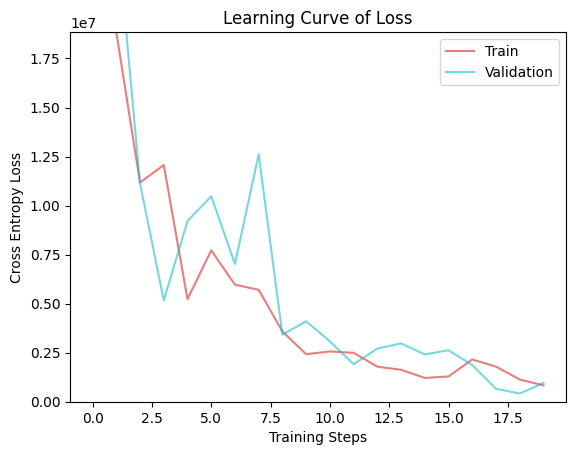

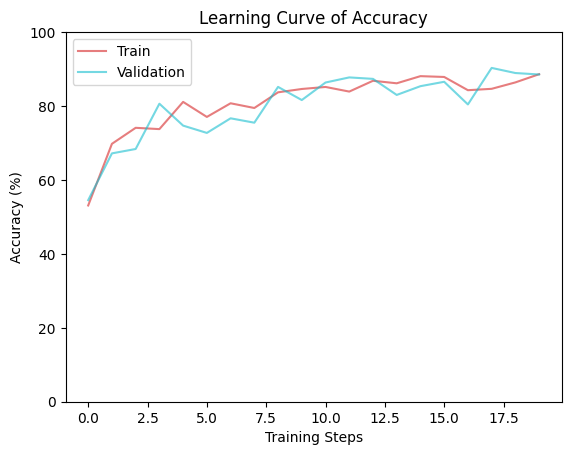

In [23]:
import matplotlib.pyplot as plt

def plot_learning_curve(record, title="", ylabel="", img=""):
    # Set figure properties
    plt.title("Learning Curve of {}".format(title))

    # Set x-axis properties
    plt.xlabel("Training Steps")
    total_steps = len(loss_record["train"])
    x = range(total_steps)

    # Set y-axis properties
    plt.ylabel(ylabel)
    if img == "loss":
        plt.ylim([0, record["train"][1]])
    elif img == "acc":
        # probability to percentage
        record = {
            "train": list(map(lambda x: x * 100, record["train"])),
            "val": list(map(lambda x: x * 100, record["val"])),
        }
        plt.ylim([0, 100])

    # Plot the data
    plt.plot(x, record["train"], c="tab:red", label="Train", alpha=0.6)
    plt.plot(x, record["val"], c="tab:cyan", label="Validation", alpha=0.6)

    # Draw the figure
    plt.legend()
    plt.show()

plot_learning_curve(loss_record, title="Loss", ylabel="Cross Entropy Loss", img="loss")
plot_learning_curve(acc_record, title="Accuracy", ylabel="Accuracy (%)", img="acc")

## Fine-Tune Model

Load the model from previous checkpoint and fine-tune it.

In [24]:
# Check device
def get_device():
    return "cuda" if torch.cuda.is_available() else "cpu"

device = get_device()
print(f"DEVICE: {device}")

# hyper-parameters
num_epoch = 200
learning_rate = 0.0001

# The path where checkpoint saved
model_path = cache_dir / "model.ckpt"

# Create model and load weights from checkpoint
model = Classifier().to(device)
model.load_state_dict(torch.load(model_path))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

DEVICE: cuda


In [25]:
# Start fine-tuning

best_acc = 0.0
loss_record = {"train": [], "val": []}
acc_record = {"train": [], "val": []}
for epoch in range(num_epoch):
    train_acc, val_acc = 0.0, 0.0
    train_loss, val_loss = 0.0, 0.0

    # Training
    model.train() # Set the model to training mode
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        batch_loss = criterion(outputs, labels)
        _, train_pred = torch.max(outputs, 1) # Get the index of the class with the highest probability
        batch_loss.backward()
        optimizer.step()

        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += batch_loss.item()

    # Validation
    if len(val_set) > 0:
        model.eval() # Set the model to evaluation mode
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels)
                _, val_pred = torch.max(outputs, 1)  # Get the index of the class with the highest probability

                val_acc += (val_pred.cpu() == labels.cpu()).sum().item()
                val_loss += batch_loss.item()

            print("[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}".format(
                epoch + 1, num_epoch,
                train_acc/len(train_set), train_loss/len(train_loader),
                val_acc/len(val_set), val_loss/len(val_loader)
            ))

            # If the model improves, save a checkpoint at this epoch
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print("Saving model with acc {:.3f}".format(best_acc/len(val_set)))

            acc_record["train"].append(train_acc/len(train_set))
            acc_record["val"].append(val_acc/len(val_set))
            loss_record["train"].append(train_loss/len(train_loader))
            loss_record["val"].append(val_loss/len(val_loader))
    else:
        print("[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}".format(
            epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader)
        ))

# If not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print("Saving model at last epoch")

[001/010] Train Acc: 0.793846 Loss: 3547697.233392 | Val Acc: 0.626482 loss: 7445714.718750
Saving model with acc 0.626
[002/010] Train Acc: 0.801538 Loss: 2504194.411058 | Val Acc: 0.745059 loss: 7385966.765625
Saving model with acc 0.745
[003/010] Train Acc: 0.816703 Loss: 2160460.723121 | Val Acc: 0.845850 loss: 1197783.878906
Saving model with acc 0.846
[004/010] Train Acc: 0.832527 Loss: 1345708.781359 | Val Acc: 0.707510 loss: 3291095.867188
[005/010] Train Acc: 0.870330 Loss: 899326.117788 | Val Acc: 0.869565 loss: 971470.574219
Saving model with acc 0.870
[006/010] Train Acc: 0.895165 Loss: 398186.185533 | Val Acc: 0.851779 loss: 689435.479492
[007/010] Train Acc: 0.894286 Loss: 292506.715035 | Val Acc: 0.814229 loss: 488928.632812
[008/010] Train Acc: 0.869670 Loss: 471206.827142 | Val Acc: 0.895257 loss: 411868.892578
Saving model with acc 0.895
[009/010] Train Acc: 0.860659 Loss: 647395.505955 | Val Acc: 0.901186 loss: 263206.457031
Saving model with acc 0.901
[010/010] Trai

## Reproduce Result

Check model's performance with validation data.

In [26]:
# Check device
def get_device():
    return "cuda" if torch.cuda.is_available() else "cpu"

device = get_device()
print(f"DEVICE: {device}")

# The path where checkpoint saved
model_path = cache_dir / "model.ckpt"

# Create model and load weights from checkpoint
model = Classifier().to(device)
model.load_state_dict(torch.load(model_path))
criterion = nn.CrossEntropyLoss()

DEVICE: cuda


In [27]:
model.eval() # Set the model to evaluation mode
with torch.no_grad():
    val_loss, val_acc = 0.0, 0.0

    for i, data in enumerate(val_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        batch_loss = criterion(outputs, labels)
        max_value, val_pred = torch.max(outputs, 1) # Get the index of the class with the highest probability

        val_acc += (val_pred.cpu() == labels.cpu()).sum().item()
        val_loss += batch_loss.item()

    print("Val Acc: {:3.6f}, Val Loss: {:3.6f}".format(
        val_acc/len(val_set), val_loss/len(val_loader)
    ))

Val Acc: 0.901186, Val Loss: 263206.457031


## Extract Activation Scores

Get activation scores from correctly classified training samples.
* Using the evaluation mode because we don't want to train model.

The model will leverage activation scores to reject unknown-I/O-pattern in testing (inference) time.

In [28]:
# Check device
def get_device():
    return "cuda" if torch.cuda.is_available() else "cpu"

device = get_device()
print(f"DEVICE: {device}")

# The path where checkpoint saved
model_path = cache_dir / "model.ckpt"

# Create model and load weights from checkpoint
model = Classifier().to(device)
model.load_state_dict(torch.load(model_path))
criterion = nn.CrossEntropyLoss()

DEVICE: cuda


In [29]:
activation_scores = [[] for i in range(N_CLASSES)]

# Set the model to evaluation mode
model.eval()
with torch.no_grad():

    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, train_pred = torch.max(outputs, 1)

        # Get activation score
        preds, labels = train_pred.cpu().tolist(), labels.cpu().tolist()
        outputs = outputs.cpu().tolist()
        for pred, label, output in zip(preds, labels, outputs):
            if pred == label:
                for i in range(N_CLASSES):
                    activation_scores[i].append(output[i])

In [30]:
import pickle

def save_activation_scores(activation_scores, o_path):
    with o_path.open("wb") as f:
        pickle.dump(activation_scores, f)

as_path = cache_dir / "activation_score.pickle"
save_activation_scores(activation_scores, o_path=as_path)